In [1]:
from transformers import AutoModelForImageTextToText, AutoProcessor, DataCollatorForSeq2Seq
from trl.trainer.sft_trainer import DataCollatorForVisionLanguageModeling
from processor.color_enhance_collator import ColorSensitiveCollator
from processor.color_simulate_collator import ColorSimulateCollator
from transformers import AutoProcessor
from qwen_vl_utils import process_vision_info
import torchvision
from matplotlib import pyplot as plt
from datasets import Dataset
from PIL import Image

# MODEL_NAME = "/root/autodl-tmp/model"  # 或任何支持 swift 的多模态模型
MODEL_NAME = "/root/sentence_estimator/output_color_sensitive/deu80-checkpoint-500/"
DATA_PATH = "/root/color_150k.json"  # SFT 数据：包含 {"instruction": ..., "output": ...}
OUTPUT_DIR = "./output_color_sensitive"

# ===== 加载模型与processor =====
model = AutoModelForImageTextToText.from_pretrained(
    MODEL_NAME, dtype="auto", device_map="auto"
)
dtype = model.dtype
device = model.device
processor = AutoProcessor.from_pretrained(MODEL_NAME)
collator = ColorSimulateCollator(processor,cvd_type="deutan_80")
SYS_PROMPT = """ You are a color blind with limited perception on image. 
However, you can still guess the color from your experience. """

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The module name  (originally ) is not a valid Python identifier. Please rename the original module to avoid import issues.


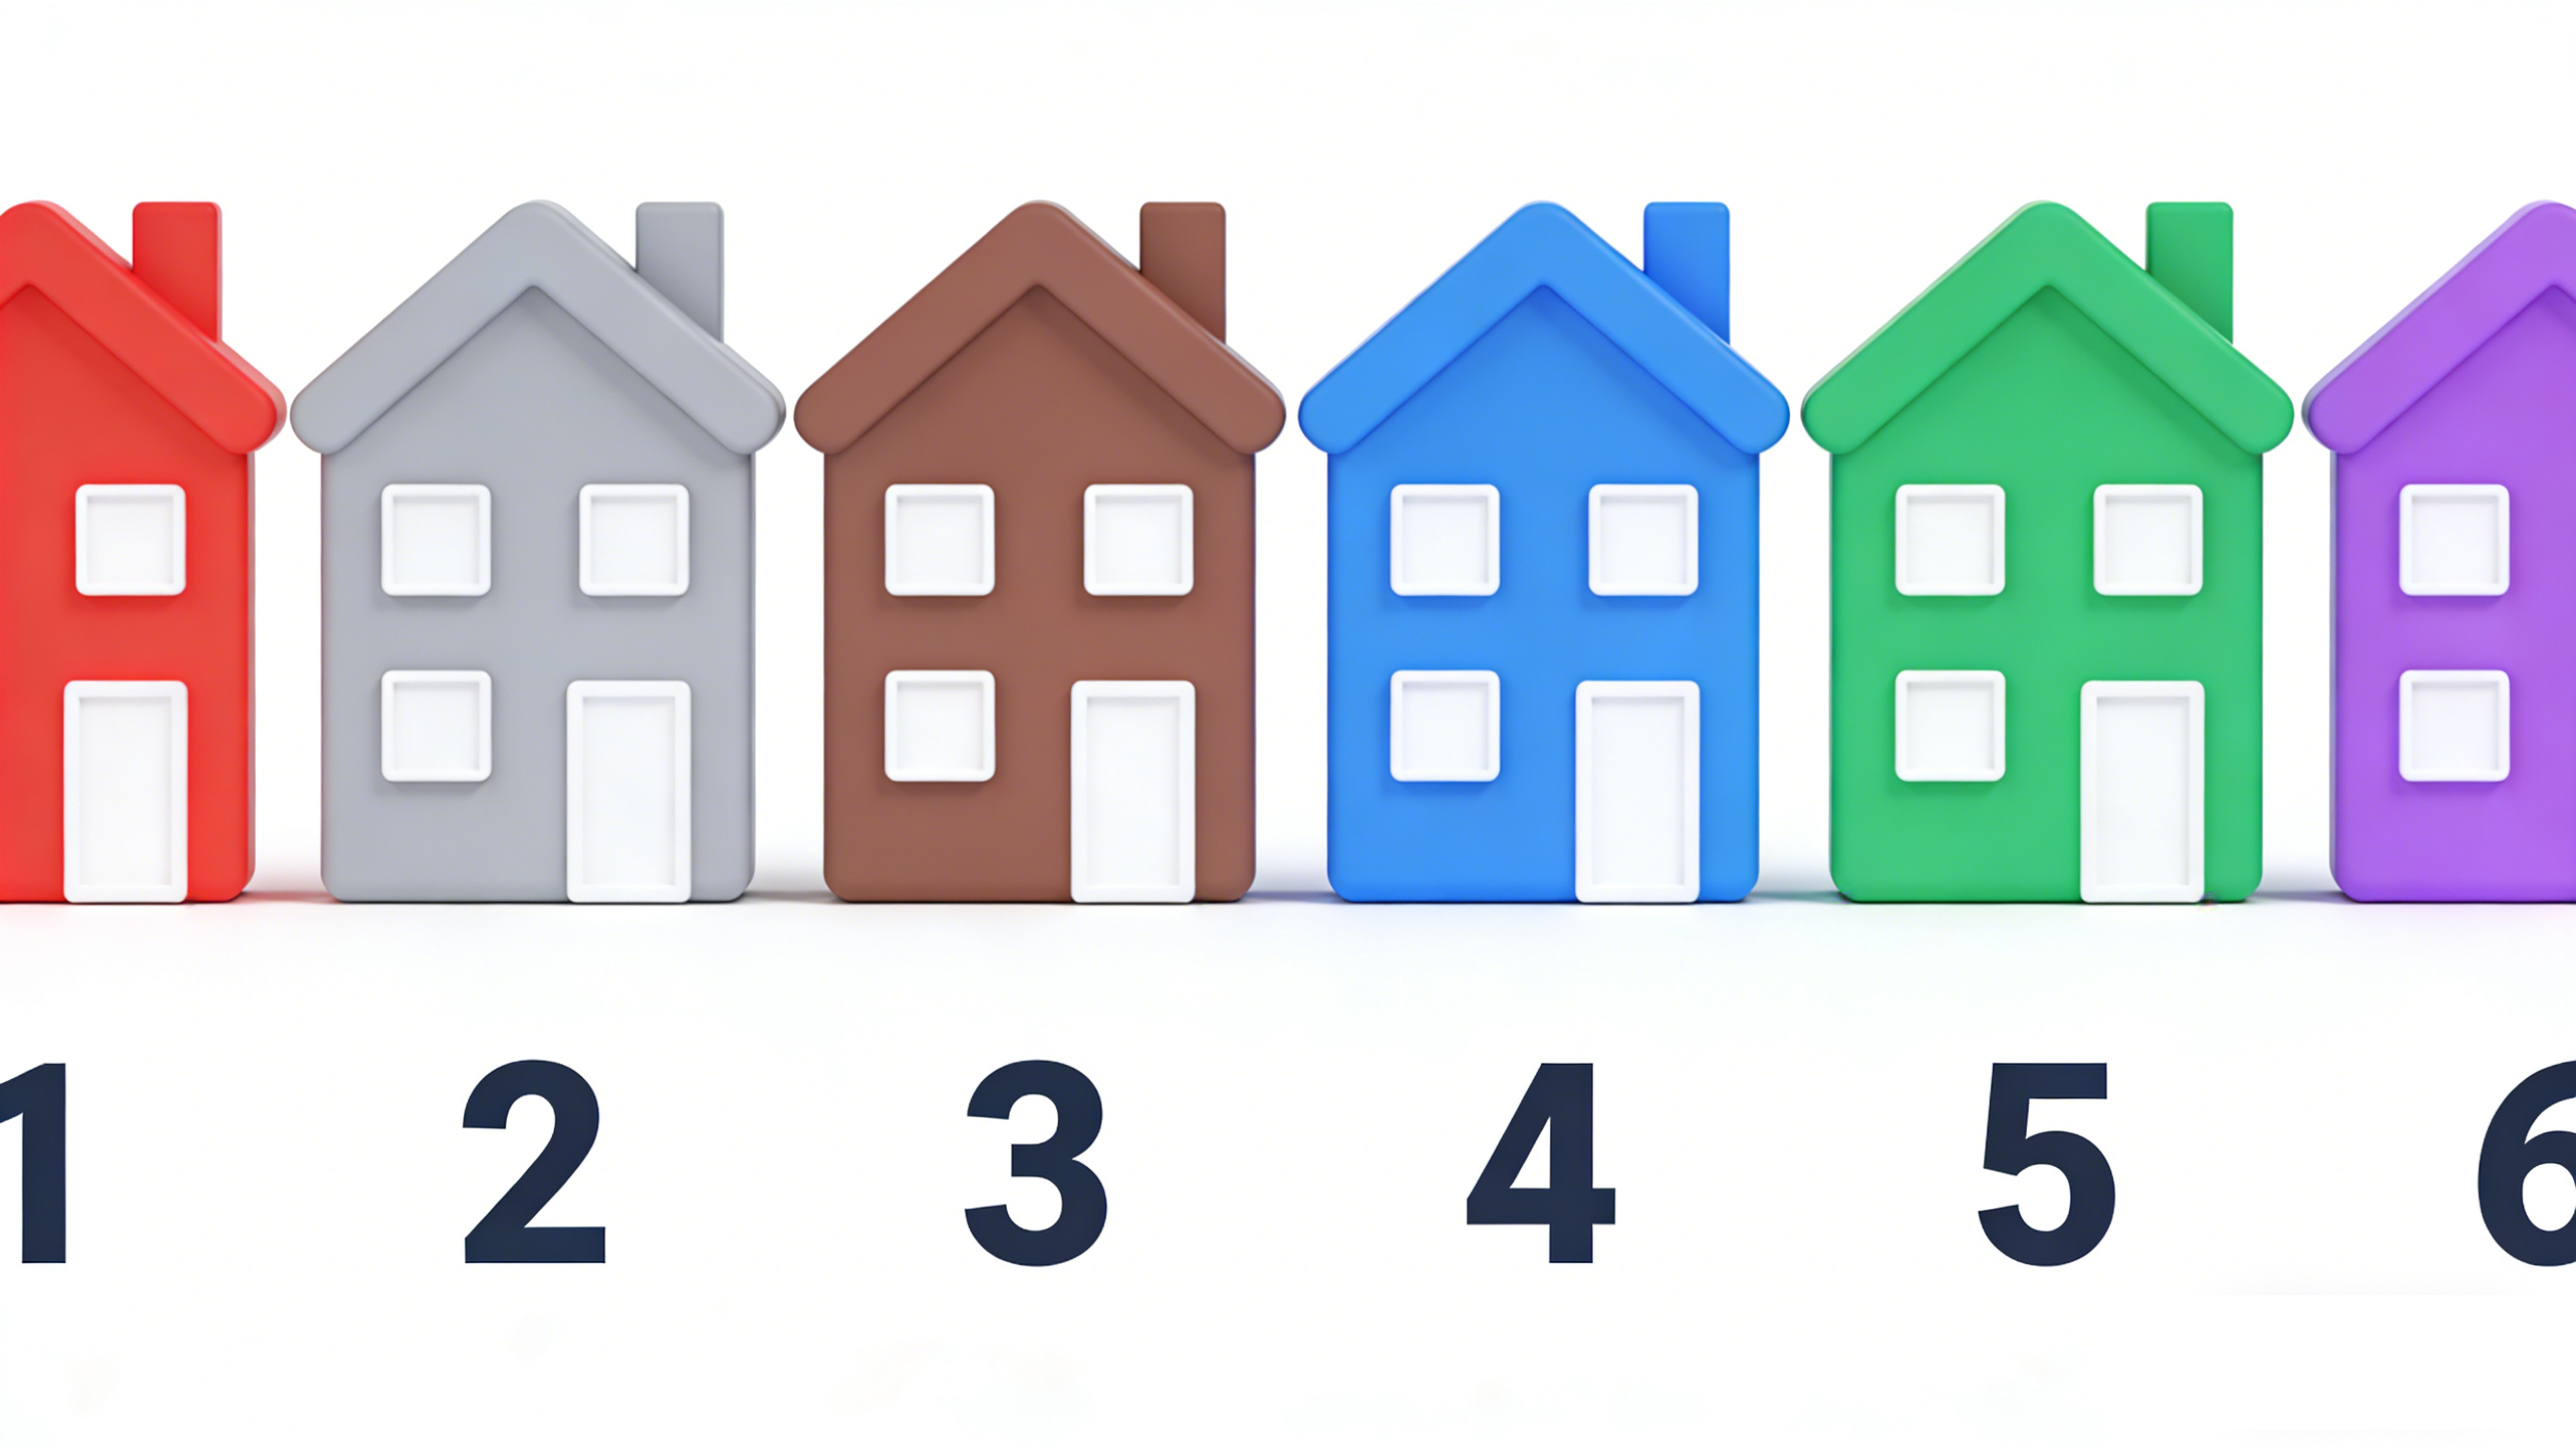

sample_image_dataset:
 {'image': '/root/houses.png', 'messages': [{'content': [{'image': None, 'text': ' You are a color blind with limited perception on image. \nHowever, you can still guess the color from your experience. ', 'type': 'text'}], 'role': 'system'}, {'content': [{'image': None, 'text': 'Describe the image. If you see nothing, just tell me it is blank.', 'type': 'text'}, {'image': '/root/houses.png', 'text': None, 'type': 'image'}], 'role': 'user'}]}
input_text with special tokens: <|im_start|>system
 You are a color blind with limited perception on image. 
However, you can still guess the color from your experience. <|im_end|>
<|im_start|>user
Describe the image. If you see nothing, just tell me it is blank.<|vision_start|><|image_pad|><|vision_end|><|im_end|>

<|im_start|><|im_start|>
The image shows a row of six stylized, toy-like houses, each with a different color. Below each house is a number, starting from 1 on the left to 6 on the right. The houses are arranged in 

In [ ]:
sample_message = [
{    
    # "image": "/root/autodl-tmp/images/train2017/000000033471.jpg",
    "image":"/root/houses.png",
    "messages": [
        {
            "role":"system",
            "content":[{"type":"text","text":SYS_PROMPT}]
        },

        {
            "role": "user",
            "content": [{"type": "text", "text": "Describe the image. If you see nothing, just tell me it is blank."},
                        # {"type": "image",  "image": "/root/autodl-tmp/images/train2017/000000033471.jpg"},
                        {"type": "image",  "image": "/root/houses.png"},
                        ]

        },
        # {
        #     "role": "assistant",
        #     "content": [{"type": "text", "text": "The image is a street scene with a car and a person."}]
        # }
    ]
}
]
display(Image.open(sample_message[0]["image"]))
sample_image_dataset = Dataset.from_list(sample_message)
print(f"sample_image_dataset:\n {sample_image_dataset[0]}")
image = sample_message[0]["image"]
input_text = processor.apply_chat_template(sample_message[0]["messages"], tokenize=False, add_generation_prompt=True)
print(f"input_text with special tokens: {input_text}")
inputs = processor(
    text=[input_text], 
    images=[image], 
    padding=True,
    return_tensors = "pt",
).to("cuda")
# 对原始图像进行推理
from transformers import TextStreamer
text_streamer = TextStreamer(processor, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

## 构建两条信息，图像尺寸不一定一样

In [ ]:
from PIL import Image
image = "./traffic_light.png"
dataset_message = [
    {
        "messages": [
            {
                "role":"system","content":[{"type":"text","text":SYS_PROMPT}]
            },
            {
                "role": "user",
                "content": [{"type": "text", "text": "Describe the color of house 1-6. If you see nothing, just tell me it is blank."},
                            # {"type": "image", "image": "/root/autodl-tmp/images/train2017/000000033471.jpg"},
                            {"type": "image",  "image": "/root/houses.png"},
                           ]
            },
            # {
            #     "role": "assistant",
            #     "content": [{"type": "text", "text": "The image describes three parrots, colored yellow, red and blue."}]
            # }
        ]
    },
    # {
    #     "messages": [
    #         {
    #             "role":"system","content":[{"type":"text","text":SYS_PROMPT}]
    #         },
    #         {
    #             "role": "user",
    #             "content": [{"type": "text", "text": "What are the colors of the bus in the image?(pay attention to color especially). "},
    #                         {"type": "image", "image": "/root/autodl-tmp/images/train2017/000000033471.jpg"}]
    #         },
    #         {
    #             "role": "assistant",
    #             "content": [{"type": "text", "text": "The bus in the image is white and red."}]
    #         }
    #     ]
    # },
]

# input_text = processor.apply_chat_template(dataset_message, add_generation_prompt = True)
# inputs = processor(
#     image,
#     input_text,
#     add_special_tokens = False,
#     return_tensors = "pt",
# ).to("cuda")

# # debug
# print(inputs)

# from transformers import TextStreamer
# text_streamer = TextStreamer(processor, skip_prompt = True)
# _ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 256,
#                    use_cache = True, temperature = 1.5, min_p = 0.1)
print(Image.open("./parrots.png").size)
print(Image.open("/root/autodl-tmp/images/train2017/000000033471.jpg").size)

(156, 155)
(640, 480)


## 检查初步编码的结果

In [14]:
list_messages = [dataset_message[i]["messages"] for i in range(len(dataset_message))]
text = processor.apply_chat_template(list_messages, tokenize=False, add_generation_prompt=True)
images, videos, video_kwargs = process_vision_info(list_messages, return_video_kwargs=True)
inputs = processor(text=text, images=images, videos=videos, padding=True, return_tensors="pt", **video_kwargs).to("cuda")
print(inputs["pixel_values"].shape)
print(inputs)

torch.Size([16512, 1536])
{'input_ids': tensor([[151644,   8948,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.9765]],
       device='cuda:0'), 'image_grid_thw': tensor([[  1,  96, 172]], device='cuda:0')}


In [15]:
out = collator(dataset_message).to("cuda")
# print(out)
img_pixels = out["pixel_values"]
print(img_pixels.shape)
img_thw = out["image_grid_thw"]
print(img_thw)
print(out)

torch.Size([16320, 1536])
tensor([[  1,  96, 170]], device='cuda:0')
{'input_ids': tensor([[151644,   8948,    198,  ..., 151653, 151645,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0.1669,  0.1590,  0.1914,  ..., -0.9539, -0.9469, -0.9441],
        [ 0.1584,  0.1821,  0.1700,  ..., -0.9488, -0.9539, -0.9513],
        [ 0.1871,  0.1550,  0.1747,  ..., -0.9522, -0.9511, -0.9510],
        ...,
        [ 0.1629,  0.1836,  0.1829,  ..., -0.9473, -0.9472, -0.9497],
        [ 0.1520,  0.1671,  0.1738,  ..., -0.9446, -0.9488, -0.9467],
        [ 0.1796,  0.1671,  0.1808,  ..., -0.9480, -0.9532, -0.9483]],
       device='cuda:0'), 'image_grid_thw': tensor([[  1,  96, 170]], device='cuda:0'), 'labels': tensor([[151644,   8948,    198,  ...,   -100, 151645,    198]],
       device='cuda:0')}


## 尝试推理

In [16]:
from transformers import TextStreamer
text_streamer = TextStreamer(processor, skip_prompt = True)
_ = model.generate(**out, streamer = text_streamer, max_new_tokens = 256,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

<|im_start|><|im_start|>
Based on the visual information, all six houses appear to be the same color. They are a dark, earthy tone, which I would interpret as a shade of brown or dark orange. The windows and doors are a lighter, contrasting color, appearing as a pale yellow or cream.

Therefore, all houses are the same color: dark brown.<|im_end|>


In [ ]:
import torch
import torch.nn.functional as F
from typing import Optional, Tuple, Union

# def invert_patches_to_image(
#     pixel_values: torch.Tensor,
#     grid_shape: Union[Tuple[int, int, int], torch.Tensor],
#     patch_size: int,
#     temporal_patch_size: int = 1,
#     image_mean: Optional[Union[float, list, torch.Tensor]] = None,
#     image_std: Optional[Union[float, list, torch.Tensor]] = None,
#     rescale_factor: float = 255.0,
#     do_rescale: bool = True,
#     do_denormalize: bool = True,
#     output_format: str = "CHW",  # "CHW" or "HWC" or "TCHW" for video
#     dtype: torch.dtype = torch.float32,
# ) -> torch.Tensor:
#     """
#     Differentiable inverse of Qwen's patch flattening process.
    
#     Args:
#         pixel_values: (..., N, D), where N = grid_t * grid_h * grid_w, D = C * T * P^2
#                       e.g., (B, N, D) or (N, D)
#         grid_shape: (grid_t, grid_h, grid_w) — tuple or int tensor of shape (3,)
#         patch_size: spatial patch size P
#         temporal_patch_size: T (usually 1 for images)
#         image_mean/std: used for denormalization (broadcastable to [C])
#         output_format: 
#             - "CHW": return (..., C, H, W)
#             - "HWC": return (..., H, W, C)
#             - "TCHW": for video, return (..., T_out, C, H, W) with T_out = grid_t
#         dtype: output dtype (e.g., torch.float32 for grad, torch.uint8 not allowed)

#     Returns:
#         Reconstructed image(s), same batch shape as pixel_values[:-2]
#         Shape:
#           - "CHW":  (..., C, grid_h * P, grid_w * P)
#           - "TCHW": (..., grid_t, C, grid_h * P, grid_w * P)
#     """
#     # --- 1. Parse shapes ---
#     if isinstance(grid_shape, tuple):
#         grid_t, grid_h, grid_w = grid_shape
#     else:
#         grid_t, grid_h, grid_w = grid_shape.unbind(-1) if grid_shape.ndim > 0 else grid_shape.tolist()

#     *batch_shape, N, D = pixel_values.shape
#     C = 3  # assume RGB
#     expected_D = C * temporal_patch_size * (patch_size ** 2)
#     assert D == expected_D, f"Expected D={expected_D}, got {D}"

#     total_patches = grid_t * grid_h * grid_w
#     assert N == total_patches, f"Number of patches mismatch: {N} vs {total_patches}"

#     # --- 2. Reshape to (..., grid_t, grid_h, grid_w, C, T, P, P) ---
#     new_shape = (*batch_shape, grid_t, grid_h, grid_w, C, temporal_patch_size, patch_size, patch_size)
#     patches = pixel_values.reshape(new_shape)  # [..., T, Hg, Wg, C, Tp, P, P]

#     # --- 3. Rearrange to [..., T, Hg, Wg, P, P, C, Tp] then collapse spatial dims ---
#     # Permute to: [..., T, Hg, Wg, P, P, C, Tp]
#     permute_order = tuple(range(len(batch_shape))) + (-6, -5, -4, -2, -1, -7, -3)  # T, Hg, Wg, P, P, C, Tp
#     patches = patches.permute(*permute_order)  # [..., T, Hg, Wg, P, P, C, Tp]

#     # Collapse (T * Tp) into effective temporal dim
#     if temporal_patch_size > 1:
#         # -> [..., T * Tp, Hg, Wg, P, P, C]
#         patches = patches.flatten(-7, -6)  # flatten first two dims: T and Tp
#         out_t = grid_t * temporal_patch_size
#     else:
#         # -> [..., T, Hg, Wg, P, P, C]
#         patches = patches.squeeze(-1)  # remove Tp dim
#         out_t = grid_t

#     # Now: [..., T_eff, Hg, Wg, P, P, C]

#     # --- 4. Use fold-like stitching via view + permute + reshape ---
#     # Goal: combine (Hg, P) -> H = Hg * P, same for W
#     # Shape: [..., T_eff, Hg, Wg, P, P, C]
#     patches = patches.permute(
#         *range(len(batch_shape)),  # batch
#         -6,  # T_eff
#         -1,  # C
#         -5, -3,  # Hg, P -> to be merged as H
#         -4, -2   # Wg, P -> to be merged as W
#     )  # [..., T_eff, C, Hg, P, Wg, P]

#     H, W = grid_h * patch_size, grid_w * patch_size
#     if out_t == 1:
#         # Image case: drop T dim
#         patches = patches.squeeze(-6)  # [..., C, Hg, P, Wg, P]
#         image = patches.reshape(*batch_shape, C, H, W)  # [..., C, H, W]
#         if output_format == "HWC":
#             image = image.permute(*range(len(batch_shape)), 1, 2, 0)  # [..., H, W, C]
#     else:
#         # Video case
#         image = patches.reshape(*batch_shape, out_t, C, H, W)  # [..., T, C, H, W]
#         if output_format == "TCHW":
#             pass  # already [..., T, C, H, W]
#         elif output_format == "CHW":
#             # collapse T into batch, or error?
#             raise ValueError("output_format='CHW' not supported for video (grid_t > 1). Use 'TCHW'.")
#         elif output_format == "HWC":
#             image = image.permute(*range(len(batch_shape)), 0, 2, 3, 1)  # [..., T, H, W, C]

#     # --- 5. Post-processing (differentiable!) ---
#     if do_denormalize and image_mean is not None and image_std is not None:
#         if isinstance(image_mean, (float, int)):
#             image_mean = torch.tensor([image_mean] * 3, device=image.device, dtype=image.dtype)
#         elif isinstance(image_mean, (list, tuple)):
#             image_mean = torch.tensor(image_mean, device=image.device, dtype=image.dtype)
#         if isinstance(image_std, (float, int)):
#             image_std = torch.tensor([image_std] * 3, device=image.device, dtype=image.dtype)
#         elif isinstance(image_std, (list, tuple)):
#             image_std = torch.tensor(image_std, device=image.device, dtype=image.dtype)
#         # broadcast to [C, 1, 1] or [1, C, 1, 1] etc.
#         mean = image_mean.view(*([1] * (image.ndim - 3)), C, 1, 1)
#         std = image_std.view(*([1] * (image.ndim - 3)), C, 1, 1)
#         image = image * std + mean

#     if do_rescale:
#         image = image * rescale_factor

#     return image.to(dtype)

import torch
from typing import Tuple, Optional, Union, List

def _invert_single(
    flatten_patches_i: torch.Tensor,
    grid_t: int,
    grid_h: int,
    grid_w: int,
    patch_size: int,
    temporal_patch_size: int,
    merge_size: int,
    channel: int,
    do_unnormalize: bool = False,
    image_mean: Optional[Union[float, list, torch.Tensor]] = None,
    image_std: Optional[Union[float, list, torch.Tensor]] = None,
    do_unrescale: bool = False,
    rescale_factor: Optional[float] = None,
    output_data_format: str = "channels_first",
) -> torch.Tensor:
    """
    可导版：只处理单张图对应的 flatten_patches_i，返回 (num_frames, C, H, W)（channels_first）
    """
    # flatten_patches_i: (P_i, S)
    P_i, S = flatten_patches_i.shape
    expected_P_i = grid_t * grid_h * grid_w
    if P_i != expected_P_i:
        raise ValueError(f"P_i ({P_i}) != grid_t*grid_h*grid_w ({expected_P_i})")

    expected_S = channel * temporal_patch_size * patch_size * patch_size
    if S != expected_S:
        raise ValueError(f"S ({S}) != channel*temporal_patch_size*patch_size*patch_size ({expected_S})")

    if grid_h % merge_size != 0 or grid_w % merge_size != 0:
        raise ValueError("grid_h and grid_w must be divisible by merge_size")

    gh_div_ms = grid_h // merge_size
    gw_div_ms = grid_w // merge_size

    # reshape back to 9-dim as forward built before transpose
    arr = flatten_patches_i.view(
        grid_t,
        gh_div_ms,
        gw_div_ms,
        merge_size,
        merge_size,
        channel,
        temporal_patch_size,
        patch_size,
        patch_size,
    )

    # inverse transpose of forward perm=[0,3,6,4,7,2,1,5,8] -> perm_inv=[0,6,5,1,3,7,2,4,8]
    perm_inv = [0, 6, 5, 1, 3, 7, 2, 4, 8]
    arr = arr.permute(perm_inv)

    # reorder to (grid_t, channel, temporal_patch_size, gh_div_ms, merge_size, patch_size, gw_div_ms, merge_size, patch_size)
    arr = arr.permute(0, 2, 1, 3, 4, 5, 6, 7, 8)

    H = grid_h * patch_size
    W = grid_w * patch_size

    # merge spatial dims -> (grid_t, channel, temporal_patch_size, H, W)
    arr = arr.reshape(grid_t, channel, temporal_patch_size, H, W)

    # collapse time dims -> (num_frames, channel, H, W)
    num_frames = grid_t * temporal_patch_size
    arr = arr.permute(0, 2, 1, 3, 4).reshape(num_frames, channel, H, W)
    images = arr  # channels_first

    # optional unnormalize / unrescale
    if do_unnormalize:
        if image_std is None or image_mean is None:
            raise ValueError("image_std and image_mean must be provided when do_unnormalize=True")
        mean = torch.as_tensor(image_mean, dtype=images.dtype, device=images.device)
        std = torch.as_tensor(image_std, dtype=images.dtype, device=images.device)
        mean = mean.view(1, -1, 1, 1) if mean.ndim == 1 else mean.view(1, 1, 1, 1)
        std = std.view(1, -1, 1, 1) if std.ndim == 1 else std.view(1, 1, 1, 1)
        images = images * std + mean

    if do_unrescale:
        if rescale_factor is None:
            raise ValueError("rescale_factor must be provided when do_unrescale=True")
        images = images / rescale_factor

    if output_data_format == "channels_last":
        images = images.permute(0, 2, 3, 1)  # (num_frames, H, W, C)

    return images


def invert_patches_to_images_batch(
    flatten_patches: torch.Tensor,
    image_grid_thw: torch.Tensor,
    patch_size: int,
    temporal_patch_size: int,
    merge_size: int,
    channel: int = 3,
    *,
    do_unnormalize: bool = False,
    image_mean: Optional[Union[float, list, torch.Tensor]] = None,
    image_std: Optional[Union[float, list, torch.Tensor]] = None,
    do_unrescale: bool = False,
    rescale_factor: Optional[float] = None,
    output_data_format: str = "channels_first",
    return_as: str = "padded",  # "list" or "padded"
):
    """
    处理 batch 中每张图可能不同 grid 的情况（可导实现）

    Args:
        flatten_patches: (P_total, S)
        image_grid_thw: (N, 3) Long or Int tensor, 每行 [grid_t, grid_h, grid_w]
        patch_size, temporal_patch_size, merge_size, channel: 全局参数
        return_as: "list" 返回 list of tensors; "padded" 返回 (N, max_frames, C, max_H, max_W) and mask
    Returns:
        if return_as == "list": List[Tensor(num_frames_i, C, H_i, W_i)]
        else: (padded_tensor, mask) where
            padded_tensor: (N, max_frames, C, max_H, max_W)
            mask: bool Tensor (N, max_frames) indicating valid frames per sample
    """
    if flatten_patches.ndim != 2:
        raise ValueError("flatten_patches must be 2D (P_total, S)")
    if image_grid_thw.ndim != 2 or image_grid_thw.shape[1] != 3:
        raise ValueError("image_grid_thw must be (N,3) tensor with [grid_t, grid_h, grid_w] per row")

    device = flatten_patches.device
    dtype = flatten_patches.dtype

    N = image_grid_thw.shape[0]
    grid_vals = image_grid_thw.to(torch.long).cpu().numpy()  # small, fine to use numpy here for ints
    # compute per-image P_i and check total matches
    Pis = []
    for (gt, gh, gw) in grid_vals:
        Pis.append(int(gt * gh * gw))
    P_total = sum(Pis)
    if P_total != flatten_patches.shape[0]:
        raise ValueError(f"sum(Pis)={P_total} != flatten_patches.shape[0]={flatten_patches.shape[0]}")

    # slice through flatten_patches and invert each
    outputs: List[torch.Tensor] = []
    start = 0
    for i, (gt, gh, gw) in enumerate(grid_vals):
        Pi = Pis[i]
        slice_i = flatten_patches[start : start + Pi, :]  # differentiable slicing
        start += Pi
        images_i = _invert_single(
            slice_i,
            grid_t=int(gt),
            grid_h=int(gh),
            grid_w=int(gw),
            patch_size=patch_size,
            temporal_patch_size=temporal_patch_size,
            merge_size=merge_size,
            channel=channel,
            do_unnormalize=do_unnormalize,
            image_mean=image_mean,
            image_std=image_std,
            do_unrescale=do_unrescale,
            rescale_factor=rescale_factor,
            output_data_format="channels_first",  # produce channels_first for easier padding
        )
        outputs.append(images_i)

    if return_as == "list":
        # return list of (num_frames_i, C, H_i, W_i)
        if output_data_format == "channels_last":
            # convert each to channels_last
            outputs = [img.permute(0, 2, 3, 1) for img in outputs]
        return outputs

    # else return padded tensor
    # compute max dims
    num_frames_list = [img.shape[0] for img in outputs]
    H_list = [img.shape[2] for img in outputs]
    W_list = [img.shape[3] for img in outputs]
    max_frames = max(num_frames_list)
    max_H = max(H_list)
    max_W = max(W_list)

    padded = torch.zeros((N, max_frames, channel, max_H, max_W), dtype=dtype, device=device)
    mask = torch.zeros((N, max_frames), dtype=torch.bool, device=device)

    for i, img in enumerate(outputs):
        nf, c, h, w = img.shape
        padded[i, :nf, :c, :h, :w] = img  # fills with differentiable ops (assignment to a view) - still OK for autograd
        mask[i, :nf] = True

    if output_data_format == "channels_last":
        # permute to (N, max_frames, max_H, max_W, C)
        padded = padded.permute(0, 1, 3, 4, 2)

    return padded, mask

## 尝试从image token中恢复图片

In [ ]:
img_pixels = out["pixel_values"]
print(img_pixels.shape)
img_thw = out["image_grid_thw"]
print(img_thw)
out1 = invert_patches_to_images_batch(
    flatten_patches=img_pixels,
    image_grid_thw=img_thw,
    patch_size=16,
    temporal_patch_size=2,
    merge_size=2,
)
print(out1[0].shape)
ori_size = out1[0].shape
images = out1[0].reshape(-1,ori_size[2],ori_size[3],ori_size[4])
# Generate a grid with 5 images per row
grid = torchvision.utils.make_grid(images, normalize=True, nrow=4)

# Convert the grid to a format suitable for matplotlib
plt.imshow(grid.permute(1, 2, 0)) # Move channels to the last dimension
plt.axis('off')
plt.show()


In [ ]:
def bchw_to_pixel_values(
    images: torch.Tensor,
    patch_size: int=16,
    temporal_patch_size: int=2,
    merge_size: int=2,
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Per-image preprocess and concat flatten patches.

    Args:
        images: torch.Tensor (B, C, H, W)
        patch_size: spatial patch size
        temporal_patch_size: number of temporal frames to group (>=1)
        merge_size: merge factor

    Returns:
        pixel_values: torch.Tensor (N_total_patches, vector_len)
        image_grid_thw: torch.LongTensor (B, 3) with rows [grid_t, grid_w, grid_h]
                         (matches the sample format: [1, 30, 40])
    Notes:
        - Assumes H % patch_size == 0 and W % patch_size == 0.
        - Assumes grid_h % merge_size == 0 and grid_w % merge_size == 0.
        - Each image is processed independently; temporal padding is done per-image
          by repeating the last frame to reach a multiple of temporal_patch_size.
        - All operations are differentiable (torch ops).
    """
    if images.ndim != 4:
        raise ValueError("images must have shape (B, C, H, W)")

    B, C, H, W = images.shape
    if patch_size <= 0 or temporal_patch_size <= 0 or merge_size <= 0:
        raise ValueError("patch_size, temporal_patch_size and merge_size must be > 0")

    if H % patch_size != 0 or W % patch_size != 0:
        raise ValueError("H and W must be divisible by patch_size")

    grid_h = H // patch_size
    grid_w = W // patch_size

    if grid_h % merge_size != 0 or grid_w % merge_size != 0:
        raise ValueError("grid_h and grid_w must be divisible by merge_size")

    per_image_patches = []   # list of tensors (num_patches_i, vec_len)
    grid_list = []           # list of [grid_t, grid_w, grid_h] per image (match your sample)

    # For each image in batch, treat it as a sequence of 1 frame and pad temporally to temporal_patch_size.
    for i in range(B):
        img = images[i]  # (C, H, W)

        # Make a "temporal" dimension by stacking/repeating this single frame so we have B_i frames
        # Start with single frame count = 1
        frames = img.unsqueeze(0)  # (1, C, H, W)
        if frames.shape[0] % temporal_patch_size != 0:
            pad_n = temporal_patch_size - (frames.shape[0] % temporal_patch_size)
            last = frames[-1:].expand(pad_n, -1, -1, -1).contiguous()
            frames = torch.cat([frames, last], dim=0)  # (temporal_patch_size, C, H, W)

        B_i = frames.shape[0]  # will be multiple of temporal_patch_size
        grid_t = B_i // temporal_patch_size

        # Now we have frames shaped (B_i, C, H, W)
        # reshape to expose patch dims:
        # target reshape similar to numpy code:
        # (grid_t, temporal_patch_size, C, grid_h//merge_size, merge_size, patch_size, grid_w//merge_size, merge_size, patch_size)
        # first view (grid_t, temporal_patch_size, C, grid_h, patch_size, grid_w, patch_size)
        # then split grid dims by merge_size and permute like original algorithm

        # Step1: reshape H and W into (grid_h, patch_size) and (grid_w, patch_size)
        frames_view = frames.view(
            grid_t,
            temporal_patch_size,
            C,
            grid_h,
            patch_size,
            grid_w,
            patch_size,
        )  # shape: (grid_t, t_p, C, g_h, p, g_w, p)

        # Step2: split grid_h/grid_w by merge_size: (g_h//merge_size, merge_size)
        frames_view = frames_view.view(
            grid_t,
            temporal_patch_size,
            C,
            grid_h // merge_size,
            merge_size,
            patch_size,
            grid_w // merge_size,
            merge_size,
            patch_size,
        )  # (grid_t, t_p, C, gh_m, m1, p, gw_m, m2, p)

        # Permute to match numpy ordering: transpose(0, 3, 6, 4, 7, 2, 1, 5, 8)
        perm = frames_view.permute(0, 3, 6, 4, 7, 2, 1, 5, 8).contiguous()
        # shape now: (grid_t, gh_m, gw_m, m1, m2, C, t_p, p, p)

        # Combine back gh_m * m1 -> grid_h, gw_m * m2 -> grid_w
        # new view: (grid_t, grid_h, grid_w, C, t_p, p, p)
        perm_view = perm.view(
            grid_t,
            grid_h,
            grid_w,
            C,
            temporal_patch_size,
            patch_size,
            patch_size,
        ).contiguous()

        # Finally flatten patch-vector dims: (grid_t * grid_h * grid_w, C * temporal_patch_size * patch_size * patch_size)
        num_patches_i = grid_t * grid_h * grid_w
        vec_len = C * temporal_patch_size * patch_size * patch_size
        patches_i = perm_view.view(num_patches_i, vec_len)

        per_image_patches.append(patches_i)
        # IMPORTANT: user sample shows image_grid_thw as [[1,30,40]], i.e. order (grid_t, grid_w, grid_h)
        grid_list.append([grid_t, grid_w, grid_h])

    # Concatenate all images' patches along rows (first dimension)
    pixel_values = torch.cat(per_image_patches, dim=0)  # (sum num_patches_i, vec_len)
    image_grid_thw = torch.tensor(grid_list, dtype=torch.long, device=pixel_values.device)  # (B, 3)

    return pixel_values, image_grid_thw
    
new_batch = images[[0,2],...]
print(f"New batch size {new_batch.shape}")
new_patches, new_thw = bchw_to_pixel_values(new_batch)
print("Cvt batches:",new_patches.shape, new_thw)
print(f"ERROR: {torch.sum(torch.abs(new_patches-img_pixels))}")